In [1]:
# If you haven't installed the bwb package yet, run the following command
# !pip install git+https://github.com/ottomossei/bwb

## import modules

In [12]:
import datetime
import numpy as np
from bwb.db import LocalDB
import bwb.basicstrategy as bst
import bwb.indicator as indicator

## Load candlestick

In [3]:
issue = 'AAPL'
d = LocalDB()
candle = d.loader(issue, start = '2020/01/01', end = datetime.date.today())
candle

,Date,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,,
2020-01-02,2020-01-02,75.150002,73.797501,74.059998,75.087502,135480400.0,74.207466
2020-01-03,2020-01-03,75.144997,74.125000,74.287498,74.357498,146322800.0,73.486023
2020-01-06,2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,74.071579
2020-01-07,2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.723213
2020-01-08,2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,74.909149
...,...,...,...,...,...,...,...
2021-06-21,2021-06-21,132.410004,129.210007,130.300003,132.300003,79663300.0,132.300003
2021-06-22,2021-06-22,134.080002,131.619995,132.130005,133.979996,74783600.0,133.979996
2021-06-23,2021-06-23,134.320007,133.229996,133.770004,133.699997,60214200.0,133.699997


## Select basic strategy

In [4]:
# RCI Cross Strategy
strategy = bst.RCICross
strategy.candle = candle
params = strategy.base_params()
params

{'span': array([ 7,  8,  9, 21, 23, 26, 42, 45, 48, 52]),
 'buy_ratio': array([-100,  -90,  -80,  -70]),
 'sell_ratio': array([ 70,  80,  90, 100])}

## backtest of all parameter

In [5]:
ef, i = np.zeros(len(params['span'])*len(params['buy_ratio'])*len(params['sell_ratio'])), 0
best_p1, best_p2, best_p3 = 0, 0, 0

for p1 in params['span']:
        for p2 in params['buy_ratio']:
                for p3 in params['sell_ratio']:
                        strategy.span = p1
                        strategy.buy_ratio = p2
                        strategy.sell_ratio = p3
                        tester = bst.Btest(
                                data = candle,
                                strategy = strategy,
                                cash = 1000,
                                commission = 0.00495,
                                margin = 1.0,
                                trade_on_close = True,
                                exclusive_orders = True
                                )
                        output = tester.run()
                        ef[i] = output['Equity Final [$]']
                        i += 1
                        if ef.max() > output['Equity Final [$]']:
                                best_p1 = p1
                                best_p2 = p2
                                best_p3 = p3
print(best_p1, best_p2, best_p3)

52 -70 100


## best parameter

In [6]:
strategy.p1 = best_p1
strategy.p2 = best_p2
strategy.p3 = best_p3
tester = bst.Btest(
        data = candle,
        strategy = strategy,
        cash = 1000,
        commission = 0.00495,
        margin = 1.0,
        trade_on_close = True,
        exclusive_orders = True
        )
output = tester.run()
output

Start                     2020-01-02 00:00:00
End                       2021-06-25 00:00:00
Duration                    540 days 00:00:00
Exposure Time [%]                   84.491979
Equity Final [$]                  2137.913577
Equity Peak [$]                   2303.618745
Return [%]                         113.791358
Buy & Hold Return [%]               77.273178
Return (Ann.) [%]                   66.857719
Volatility (Ann.) [%]               54.606703
Sharpe Ratio                          1.22435
Sortino Ratio                        3.292442
Calmar Ratio                          3.30122
Max. Drawdown [%]                  -20.252425
Avg. Drawdown [%]                   -4.434442
Max. Drawdown Duration      150 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                    2
Win Rate [%]                            100.0
Best Trade [%]                      98.658217
Worst Trade [%]                       8.33432
Avg. Trade [%]                    

## Save .html

In [7]:
p = tester.plot(issue=issue, open_browser=True)

## Show with mplfinance

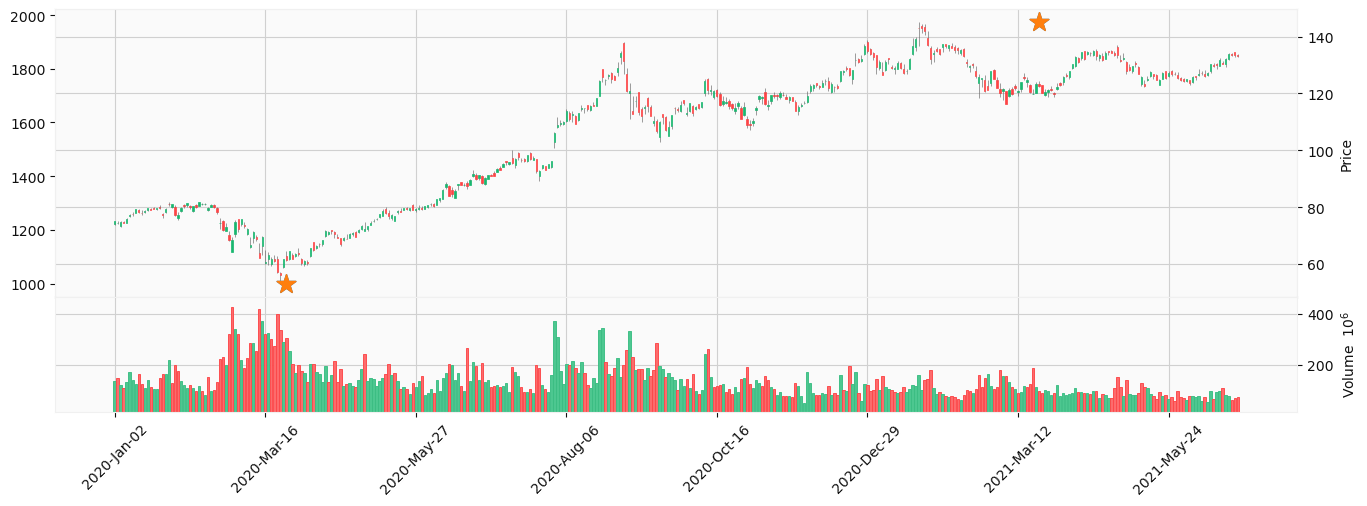

In [11]:
import mplfinance as mpf
import pandas as pd
buy = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['EntryBar']], index=output['_equity_curve'].index)
sell = pd.DataFrame(data = output['_equity_curve']['Equity'][output['_trades']['ExitBar']], index=output['_equity_curve'].index)
# Show with Jupyter Notebook
# idc = mpf.make_addplot(indicator.rci(candle, best_p1))
apds = [mpf.make_addplot(buy,type='scatter',markersize=200,marker='*'),
        mpf.make_addplot(buy,type='scatter',markersize=200,marker='*')]

mpf.plot(candle, type='candle', figratio=(12,4),
         volume=True, style='yahoo', addplot=apds)

## Equity data

In [9]:
print(output['_equity_curve'])

                 Equity  DrawdownPct DrawdownDuration
2020-01-02  1000.000000     0.000000              NaT
2020-01-03  1000.000000     0.000000              NaT
2020-01-06  1000.000000     0.000000              NaT
2020-01-07  1000.000000     0.000000              NaT
2020-01-08  1000.000000     0.000000              NaT
...                 ...          ...              ...
2021-06-21  2120.153568     0.079642              NaT
2021-06-22  2147.033450     0.067974              NaT
2021-06-23  2142.553470     0.069918              NaT
2021-06-24  2137.913577     0.071933              NaT
2021-06-25  2137.913577     0.071933         150 days

[374 rows x 3 columns]


## Trade data

In [10]:
print(output['_trades'])

   Size  EntryBar  ExitBar  EntryPrice   ExitPrice         PnL  ReturnPct  \
0    16        57      307   61.683832  122.540001  973.698701   0.986582   
1    16       307      372  123.146574  133.410004  164.214876   0.083343   

   EntryTime   ExitTime Duration  
0 2020-03-25 2021-03-23 363 days  
1 2021-03-23 2021-06-24  93 days  
